In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [233]:
batch_size = 100
learning_rate = 1e-3
num_epochs = 100

In [234]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)

In [235]:
data_train = datasets.CIFAR10('data', train=True)
data_train = [data_train[i] for i in range(len(data_train)) if data_train[i][1] == 5]
process = transforms.Compose([
    transforms.ToTensor()
])
data_train = [[process(data_train[i][0]), data_train[i][1]] for i in range(len(data_train))]

data_test = datasets.CIFAR10('data', train=False)
data_test = [data_test[i] for i in range(len(data_test)) if data_test[i][1] == 5]
data_test = [[process(data_test[i][0]), data_test[i][1]] for i in range(len(data_test))]


train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    data_test,
    batch_size=1)

In [236]:
class VAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=32*24*24, zDim=64):
        super(VAE, self).__init__()
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)
        
    def encoder(self, x):
        
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*24*24)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 24, 24)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x
        
    def forward(self, x):
        
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
    

In [237]:
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [238]:
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch {}: Loss {}'.format(epoch, loss))

Epoch 0: Loss 206480.796875
Epoch 1: Loss 199026.984375
Epoch 2: Loss 190614.734375
Epoch 3: Loss 189903.09375
Epoch 4: Loss 187487.140625
Epoch 5: Loss 189757.890625
Epoch 6: Loss 189571.359375
Epoch 7: Loss 186867.78125
Epoch 8: Loss 185689.71875
Epoch 9: Loss 188684.765625
Epoch 10: Loss 187452.1875
Epoch 11: Loss 182630.828125
Epoch 12: Loss 185627.5625
Epoch 13: Loss 185152.296875
Epoch 14: Loss 185101.609375
Epoch 15: Loss 187292.484375
Epoch 16: Loss 183816.890625
Epoch 17: Loss 184510.453125
Epoch 18: Loss 186125.609375
Epoch 19: Loss 188324.75
Epoch 20: Loss 183675.71875
Epoch 21: Loss 186107.171875
Epoch 22: Loss 184106.921875
Epoch 23: Loss 180926.34375
Epoch 24: Loss 182849.125
Epoch 25: Loss 181098.921875
Epoch 26: Loss 182885.4375
Epoch 27: Loss 181808.78125
Epoch 28: Loss 182451.078125
Epoch 29: Loss 180044.140625
Epoch 30: Loss 180785.484375
Epoch 31: Loss 182596.671875
Epoch 32: Loss 182710.09375
Epoch 33: Loss 185383.78125
Epoch 34: Loss 182190.21875
Epoch 35: Loss 18

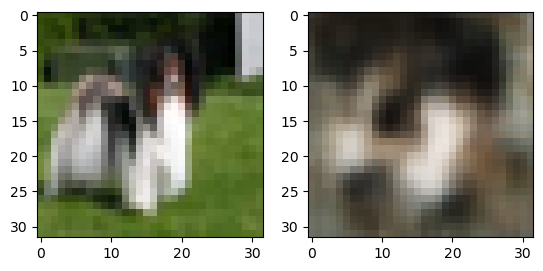

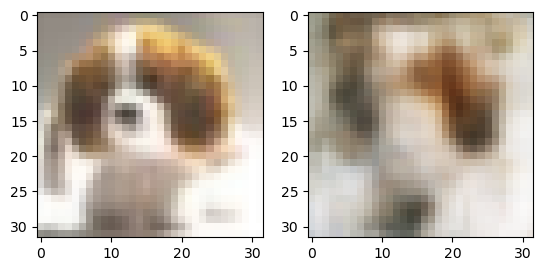

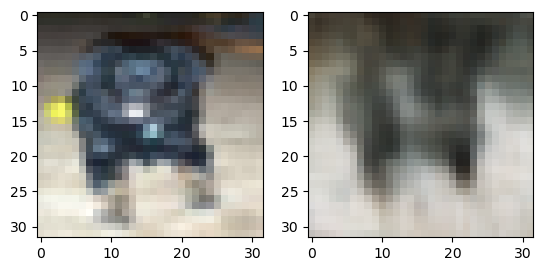

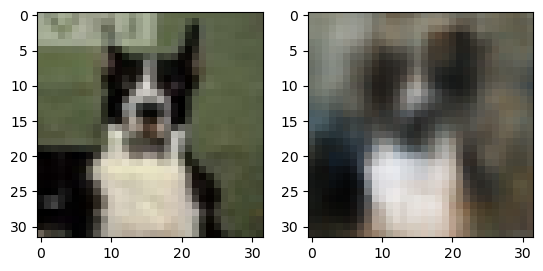

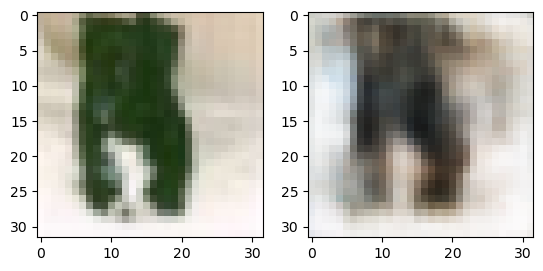

In [239]:
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 5):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        plt.show()